# LSTM MNIST Example


## Started May 28, 2019
### Genevieve Hayes

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import time

# Load MNIST Dataset

In [3]:
train_dataset = dsets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = dsets.MNIST(root='./data',train=False,transform=transforms.ToTensor())

In [9]:
train_len = len(train_dataset)
test_len = len(test_dataset)

print(train_len)
print(test_len)

# print(train_dataset.train_data.size())
# print(train_dataset.train_labels.size())
# print(test_dataset.test_data.size())
# print(test_dataset.test_labels.size())

60000
10000


# Make Dataset Iterable

In [11]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters/(len(train_dataset)/batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)


In [22]:
print(train_loader.size())
print(len(test_loader))
print(num_epochs)

AttributeError: 'DataLoader' object has no attribute 'size'

# Create LSTM Model Class

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel,self).__init__()
        #Hidden dimensions
        self.hidden_dim = hidden_dim
        
        #Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the LSTM
        #batch_first=True causes input/output tensors to be of shape (batch, seq_dim, feature)
        self.lstm = nn.LSTM(input_dim,hidden_dim,layer_dim,batch_first=True)
        
        #Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self,x):
        #Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).requires_grad_()
        
        #Initialize cell state
        c0 = torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).requires_grad_()
        
        #28 time steps
        #We need to detach as we are doing truncates backpropagation through time (BPTT)
        #If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        #Index hidden state of last time step
        # out.size() --> 100,28,100
        # out[:,-1,:] --> 100,100 --> only want hidden states of last time step
        out = self.fc(out[:, -1, :])
        #out.size() --> 100,10
        return out

In [14]:
########################
#Instantiate Model Class
########################

input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#Instantiate Loss Class
#######################

criterion = nn.CrossEntropyLoss()

############################
#Instantiate Optimizer Class
############################

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [15]:
len(list(model.parameters())) 
#We have 6 groups of parameters comprising weights and biases from: 
#1. Input to Hidden Layer Affine Func, 
#2. Hidden Layer to Output Affine Func
#3. Hidden Layer to Hidden Lay Affine Func

for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([400, 28])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([10, 100])
torch.Size([10])


# Train Model

In [34]:
#number of steps to unroll (28x28 size images)
seq_dim = 28

iter = 0
train_loss = 0
test_loss = 0
train_corrects = 0
test_corrects = 0

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        #Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        print(images.size())
        #Clear gradients with respect to parameters
        optimizer.zero_grad()
        
        #Forward pass to get output/logits
        #outputs.size() --> 100,10
        outputs = model(images)
        
        #Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs,labels)
        
        #Getting gradients with respect to parameters
        loss.backward()
        
        #Updating parameters
        optimizer.step()
        
        #Store training loss and corrects
        train_loss += loss.item()*images.size(0)
        train_corrects += loss.item()*images.size(0)
        
        iter += 1   
        
        if iter % 500 == 0:
            #Calculate Accuracy
            correct = 0
            total = 0
            #Iterate through test dataset
            for images, labels in test_loader:
                #Resize images
                images = images.view(-1,seq_dim,input_dim)
                
                #Forward pass only to get logits/output
                outputs = model(images)
                
                #Get predicted from the maximum value
                _, predicted = torch.max(outputs.data,1)
                
                #Total number of labels
                total += labels.size(0)
                
                test_loss += loss.item()*images.size(0)
            
                #extract TP+TN
                test_corrects += torch.sum(predicted == labels.data)
                
                #Total correct predictions
                correct += (predicted == labels).sum()
                
                TESTaccuracy = 100*correct/total
            
            #Print loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter,loss.item(),TESTaccuracy))

torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])


KeyboardInterrupt: 

In [33]:
start_time = time.time()

#number of steps to unroll (28x28 size images)
seq_dim = 28

iter = 0
train_loss = 0
test_loss = 0
train_corrects = 0
test_corrects = 0
correct = 0

training_loss_list=[]
test_loss_list=[]
testing_loss_list=[]

training_acc_list=[]
test_acc_list = []
testing_acc_list=[]

for epoch in range(num_epochs):
    if (epoch%1==10 or epoch==num_epochs - 1):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 2)
        
    model.train()
    train_loss = 0.0
    train_corrects = 0 
    
    for i, (images,labels) in enumerate(train_loader):
        #Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        #Clear gradients with respect to parameters
        optimizer.zero_grad()
        
        #Forward pass to get output/logits
        #outputs.size() --> 100,10
        outputs = model(images)
        
        #Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs,labels)
        #Getting gradients with respect to parameters
        loss.backward()
        #Updating parameters
        optimizer.step()
        
        #Store training loss and corrects
        train_loss += loss.item()*images.size(0)
        
        train_corrects += loss.item()*images.size(0)
        
        total = labels.size(0)
        
        train_accuracy = 100*correct/total
        
        #training_acc_list.append(train_accuracy)
        #train_loss.append(train_loss)
        
    iter += 1         
    if iter % 500 == 0:
        #Calculate Accuracy
        test_corrects = 0
        correct = 0
        total = 0
        #Iterate through test dataset
        for images, labels in test_loader:
        #Resize images
            images = images.view(-1,seq_dim,input_dim)
            
            #Forward pass only to get logits/output
            outputs = model(images)
            
            #Get predicted from the maximum value
            _, predicted = torch.max(outputs.data,1)
            
            #Total number of labels
            total += labels.size(0)                
            test_loss += loss.item()*images.size(0)
            
            #Total correct predictions
            correct += (predicted == labels).sum()
                
            TESTaccuracy = 100*correct/total
                
        #test_acc_list.append(TESTaccuracy)
        #test_loss.append(test_loss)
            
        #Print loss
        print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter,loss.item(),TESTaccuracy))
            
end_time = time.time()   
print("--- {} seconds ---".format(end_time-start_time)) 
print("--- {} min and {} sec ---".format(math.floor((end_time-start_time)/60),math.ceil((end_time-start_time)%60)))

KeyboardInterrupt: 

In [23]:
##########################################
##########################################
##########################################
#train MNIST LSTM that MAKES SENSE

#number of steps to unroll (28x28 size images)
seq_dim = 28

#initialize variables
iter = 0
train_loss = 0
train_corrects = 0
total = 0

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        #Load images as torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        #Clear gradients with respect to parameters
        optimizer.zero_grad()
        
        #Forward pass to get output/logits
        #outputs.size() --> 100,10
        outputs = model(images)
        
        #Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs,labels)
        #Getting gradients with respect to parameters
        loss.backward()
        #Updating parameters
        optimizer.step()
        
        #Store the training loss and # of corrects and total number of events
        train_loss += loss.item()*images.size(0)   
        total = labels.size(0)
        
        #extract TP+TN
        #train_corrects += torch.sum(outputs == labels.data)
        
    #epoch_loss = train_loss/train_len
    #epoch_acc = train_corrects/train_len
    
    print(train_loss/train_len)

2.2814002470175425
3.752638613382975


KeyboardInterrupt: 

In [31]:
print(labels.size())
print(outputs.size())
#outputs == labels

torch.Size([100])
torch.Size([100, 10])


# Evaluate Model

In [90]:
print(len(outputs))
print(outputs.size())
print(outputs.type())
print(outputs[1])

indnp = np.argmax([1,2,3,4,5])
#indnp = np.argmax(outputs)

print(indnp)


val,ind = torch.max(outputs,1)
print(ind)
#ind = outputs[1].max(0)
#print(ind.type())

100
torch.Size([100, 10])
torch.FloatTensor
tensor([-2.2314, -2.7231, -4.6334, -0.4806,  1.7836, -0.3315, -5.1610,  1.3123,
         0.7714,  9.8100], grad_fn=<SelectBackward>)
4
tensor([8, 9, 0, 1, 2, 7, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6, 9, 1,
        9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3, 3, 9, 1, 4,
        0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3, 6, 8, 7, 1, 5, 2,
        4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6])


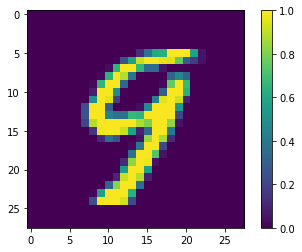

In [48]:
plt.figure()
plt.imshow(images[1])
plt.colorbar()
plt.grid(False)
plt.show()

In [91]:
# ##Trying to plot number along with model output

# import numpy as np
# # Create functions to graph the image along with confidence levels

# #plot image function plots the image of interest along with prediction and truth labels
# def plot_image(i,predictions_array, true_label,img):
#     predictions_array,true_label,img = predictions_array[i], true_label[i], img[i]
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
    
#     plt.imshow(img, cmap=plt.cm.RdGy)

#     #predicted_label = np.argmax(predictions_array)
#     predicted_label = predictions_array.max(0)

#     if predicted_label == true_label:
#         color = 'green'
#     else:
#         color = 'red'
        
#     plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
#                                             100*np.max(predictions_array),
#                                             class_names[true_label]),
#                                             color = color)

# #plot value function creates a bar graph of the confidence levels, colored according to correctness       
# def plot_value_array(i,predictions_array,true_label):
#     predictions_array,true_label = predictions_array[i], true_label[i]
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
#     thisplot = plt.bar(range(10),predictions_array, color = "#777777")
#     plt.ylim([0,1])
#     #predicted_label = np.argmax(predictions_array)
#     predicted_label = predictions_array.max(0)
    
#     thisplot[predicted_label].set_color('red')
#     thisplot[true_label].set_color('green')



# # plot one of them!
# i = 4 
# plt.figure(figsize=(6,3))
# plt.subplot(1,2,1)
# plot_image(i,outputs,labels,images)
# #plt.subplot(1,2,2)
# #plot_value_array(i,outputs,test_labels)
# #plt.show()